## G@C recycling volume per capita & G@C share of hk total (+ show the increase percentage of volume)

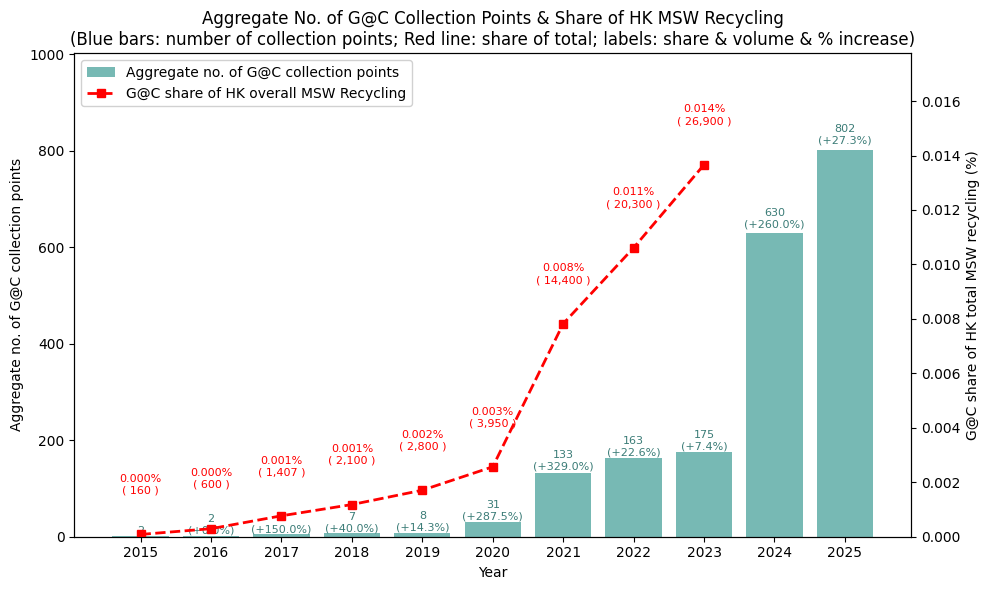

In [15]:
# ---------- install deps if missing ----------
import importlib, subprocess, sys

def _ensure(pkg, mod=None):
    try:
        importlib.import_module(mod or pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

_ensure("pandas")
_ensure("numpy")
_ensure("openpyxl")
_ensure("matplotlib")

# ---------- imports ----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- load data ----------
data_path = Path("../General Stats_G@C_clean.xlsx")
df = pd.read_excel(data_path, engine="openpyxl")

# ---------- column names ----------
col_points = "Number of G@C collection points"
col_share  = "G@C share of HK total MSW recycling"
col_volume = "G@C recyclables collection volume (tonnes)"

# =====================================================
# 1) BAR DATA: all years where collection points exist
# =====================================================
points_sub = df[[col_points, "Year"]].copy()
points_sub = points_sub[points_sub[col_points].notna()].copy()

points_sub["Year"]   = points_sub["Year"].astype(int)
points_sub[col_points] = pd.to_numeric(points_sub[col_points], errors="coerce")

# sort by year
points_sub = points_sub.sort_values("Year")

# year-on-year % change for bars
points_sub["points_pct_change"] = points_sub[col_points].pct_change() * 100

years_all = points_sub["Year"].tolist()
points_all = points_sub[col_points].tolist()

# create x positions for ALL years
x_all = np.arange(len(years_all))
year_to_x = {y: i for i, y in enumerate(years_all)}

# =====================================================
# 2) LINE DATA: only years where share & volume exist
#    (line will stop at the last such year, e.g. 2023)
# =====================================================
line_sub = df[[col_share, col_volume, "Year"]].copy()
line_sub = line_sub[line_sub[col_share].notna() & line_sub[col_volume].notna()].copy()

line_sub["Year"] = line_sub["Year"].astype(int)

# convert share from "0.01%" to float 0.01 etc.
line_sub["share_pct"] = (
    line_sub[col_share].astype(str).str.rstrip("%").replace("", np.nan).astype(float)
)

# volume numeric
line_sub[col_volume] = pd.to_numeric(
    line_sub[col_volume].astype(str).str.replace(",", ""),
    errors="coerce"
)

line_sub = line_sub.sort_values("Year")

years_line   = line_sub["Year"].tolist()
share_line   = line_sub["share_pct"].tolist()
volume_line  = line_sub[col_volume].tolist()

# x positions for the line (mapped to bar positions)
x_line = [year_to_x[y] for y in years_line if y in year_to_x]
# also filter share/volume to match (just in case)
share_line  = [s for y, s in zip(years_line, share_line) if y in year_to_x]
volume_line = [v for y, v in zip(years_line, volume_line) if y in year_to_x]

# ---------- plotting ----------
fig, ax1 = plt.subplots(figsize=(10, 6))

# ----- Bars: aggregate no. of points -----
bars = ax1.bar(
    x_all,
    points_all,
    alpha=0.8,
    color="#55a8a2",
    label="Aggregate no. of G@C collection points"
)
ax1.set_xlabel("Year")
ax1.set_ylabel("Aggregate no. of G@C collection points", color="black")
ax1.tick_params(axis="y", labelcolor="black")
ax1.set_xticks(x_all)
ax1.set_xticklabels([str(y) for y in years_all], rotation=0)

# extra space for bar labels
y1_max = max(points_all)
ax1.set_ylim(0, y1_max * 1.25)

# bar labels: Value (%Change)
for bar, value, pct in zip(bars, points_all, points_sub["points_pct_change"]):
    height = bar.get_height()
    if np.isnan(pct):
        label = f"{int(value)}"
    else:
        label = f"{int(value)}\n({pct:+.1f}%)"
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        height * 1.01,
        label,
        ha="center",
        va="bottom",
        color="#3b7c77",
        fontsize=8,
    )

# ----- Line: G@C share of HK MSW recycling (up to 2023) -----
ax2 = ax1.twinx()
line, = ax2.plot(
    x_line,
    share_line,
    color="red",
    marker="s",
    linewidth=2,
    linestyle="--",
    label="G@C share of HK overall MSW Recycling",
)
ax2.set_ylabel("G@C share of HK total MSW recycling (%)", color="black")
ax2.tick_params(axis="y", labelcolor="black")

# right y-axis starts at 0
if len(share_line) > 0:
    y2_max = max(share_line) * 1.3
else:
    y2_max = 1.0
ax2.set_ylim(0, y2_max)

# label offset for line labels
label_offset = y2_max * 0.08

# line labels: share (%) + volume
for xi, share, vol in zip(x_line, share_line, volume_line):
    ax2.text(
        xi,
        share + label_offset,
        f"{share:.3f}%\n( {vol:,.0f} )",
        ha="center",
        va="bottom",
        fontsize=8,
        color="red",
    )

# ----- Legend, title, layout -----
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    handles1 + handles2,
    labels1 + labels2,
    loc="upper left",
    frameon=True,
    fancybox=True,
    framealpha=0.9,
)

plt.title(
    "Aggregate No. of G@C Collection Points & Share of HK MSW Recycling\n"
    "(Blue bars: number of collection points; Red line: share of total; "
    "labels: share & volume & % increase)"
)

fig.tight_layout()
plt.show()
